### 라이브러리

In [35]:
import pandas as pd 
import numpy as np
import random
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf
import copy as cp
import pathlib
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import Concatenate

### 데이터 불러오기

In [36]:
data_dir = pathlib.Path('./waste_classifier_dataset/')
data_dir

WindowsPath('waste_classifier_dataset')

In [37]:
batch_size = 16
img_height = 160
img_width = 160

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 5215 files belonging to 4 classes.
Using 4694 files for training.
Found 5215 files belonging to 4 classes.
Using 521 files for validation.
['call waste', 'paper', 'recycle', 'waste']


### 데이터 증강

In [38]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### 모델 생성

In [39]:
from keras.applications.vgg19 import VGG19
# 모델 생성
from tensorflow.keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , Dropout, Flatten 


base_model = VGG19(input_shape=(img_height, img_width , 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

from keras.layers import Dense , GlobalAveragePooling2D

global_average_layer = GlobalAveragePooling2D()
# prediction_layer = Dense(100)



VGGmodel2 = tf.keras.Sequential([
  data_augmentation,
  base_model,
  global_average_layer,
  Flatten(),
  Dense(64,activation="relu"),
  Dense(16,activation="relu"),
  Dense(len(class_names), activation="softmax")
])


VGGmodel2.compile(loss="sparse_categorical_crossentropy",optimizer = 'adam', metrics=["accuracy"])

In [40]:
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 3, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/Ch14-4-bestmodel.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)



In [41]:
history= VGGmodel2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,

                       
                       
                       callbacks=[early_stopping_callback,checkpointer]
                      )

Epoch 1/20
294/294 [==============================] - 15s 46ms/step - loss: 0.5339 - accuracy: 0.8306 - val_loss: 0.2520 - val_accuracy: 0.9040
Epoch 2/20
294/294 [==============================] - 14s 46ms/step - loss: 0.2853 - accuracy: 0.9003 - val_loss: 0.1721 - val_accuracy: 0.9424
Epoch 3/20
294/294 [==============================] - 14s 47ms/step - loss: 0.2366 - accuracy: 0.9167 - val_loss: 0.1614 - val_accuracy: 0.9482
Epoch 4/20
294/294 [==============================] - 14s 47ms/step - loss: 0.2032 - accuracy: 0.9284 - val_loss: 0.1268 - val_accuracy: 0.9559
Epoch 5/20
294/294 [==============================] - 14s 48ms/step - loss: 0.1874 - accuracy: 0.9301 - val_loss: 0.1363 - val_accuracy: 0.9501
Epoch 6/20
294/294 [==============================] - 14s 48ms/step - loss: 0.1712 - accuracy: 0.9352 - val_loss: 0.1271 - val_accuracy: 0.9482
Epoch 7/20
294/294 [==============================] - 14s 48ms/step - loss: 0.1628 - accuracy: 0.9399 - val_loss: 0.1310 - val_accuracy:

### 시각화

<Figure size 864x288 with 0 Axes>

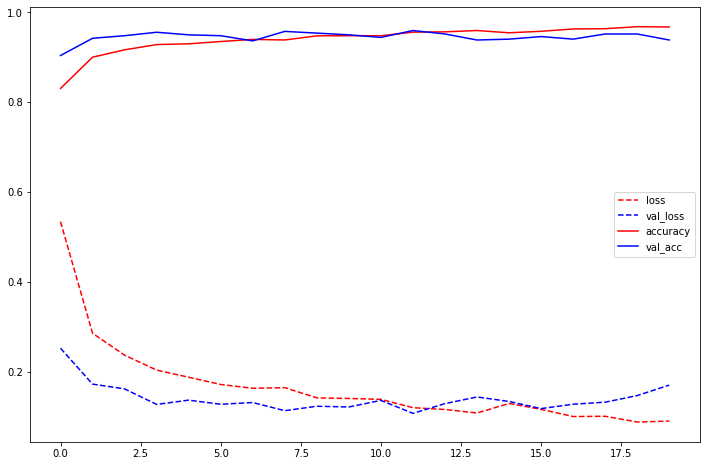

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'--',c='red')
plt.plot(history.history['val_loss'],'--',c='blue')
plt.plot(history.history['accuracy'],c='red')
plt.plot(history.history['val_accuracy'],c='blue')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

In [43]:
VGGmodel2.evaluate(val_ds)
# 손실값, 정확도

33/33 [==============================] - 2s 38ms/step - loss: 0.1699 - accuracy: 0.9386


[0.16986876726150513, 0.9385796785354614]

### 테스트

(160, 160, 3)
(1, 160, 160, 3)
This image most likely belongs to recycle with a 47.54 percent confidence.


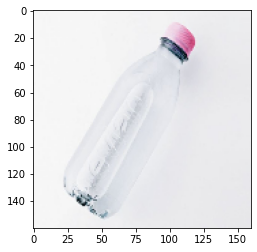

In [44]:
import keras

sunflower_url = "./test.jpg"


img = keras.preprocessing.image.load_img(
    sunflower_url, target_size=(img_height, img_width)
)

plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
print(np.shape(img_array))

img_array = tf.expand_dims(img_array, 0) # Create a batch
print(np.shape(img_array))

predictions = VGGmodel2.predict(img_array)


score = tf.nn.softmax(predictions[0])
score
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)